# Simulation test

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, Product

from scipy.sparse import csr_matrix
from util_fun import calculate_error_nrms

In [2]:
from data import load_narx_data, load_data

n_a, n_b = 2, 2
Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
total_number_of_points = 25000 # total number of points to consider from the larger dataset (starting from index 0)

Xtrain_NARX, Ytrain_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="train", split=Split, as_tensor=False)
Xval_NARX, Yval_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="validation", split=Split, as_tensor=False)
Xtest_NARX, Ytest_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="test", split=Split, as_tensor=False)

Considering 25000 datapoints
Using 15000 datapoints for training set
Considering 25000 datapoints
Using 5000 datapoints for validation set
Considering 25000 datapoints
Using 5000 datapoints for test set


In [3]:
XtrainNARXSparse = csr_matrix(Xtrain_NARX).toarray()
YtrainNARXSparse = csr_matrix(Ytrain_NARX).toarray().transpose()

In [4]:
kernel = RBF(length_scale_bounds=[1,50]) + WhiteKernel(noise_level_bounds=[1e-6,1e-2])
reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=5)

reg.fit(XtrainNARXSparse, YtrainNARXSparse)

print(reg.kernel_)

RBF(length_scale=4.59) + WhiteKernel(noise_level=1.92e-05)


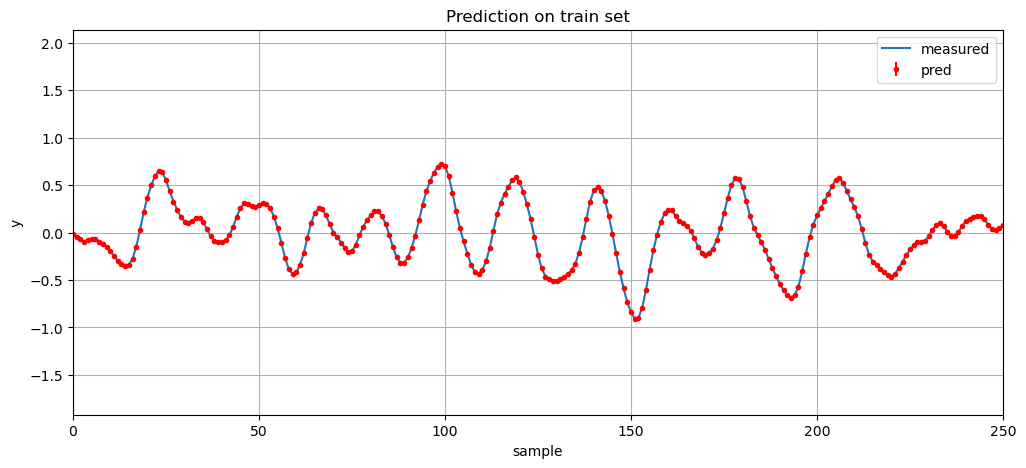

Train prediction NRMS: 0.90 %


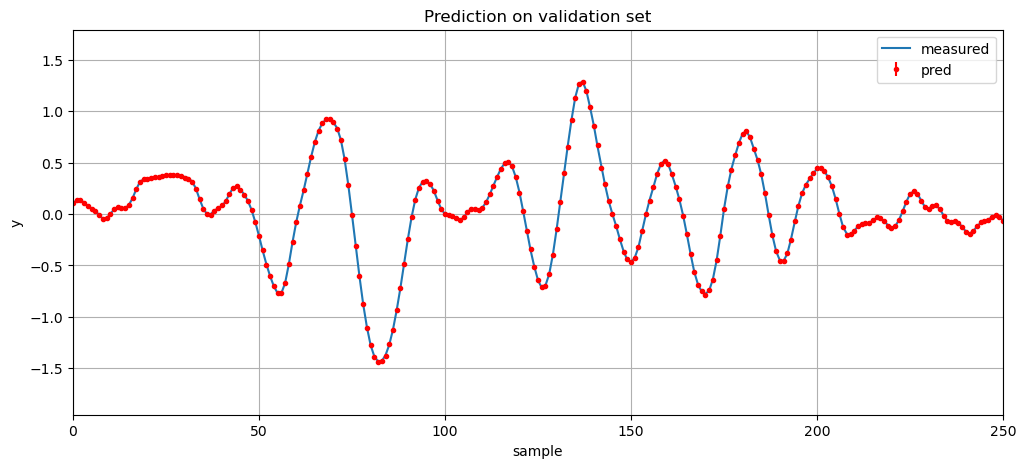

Validation prediction NRMS: 0.81 %


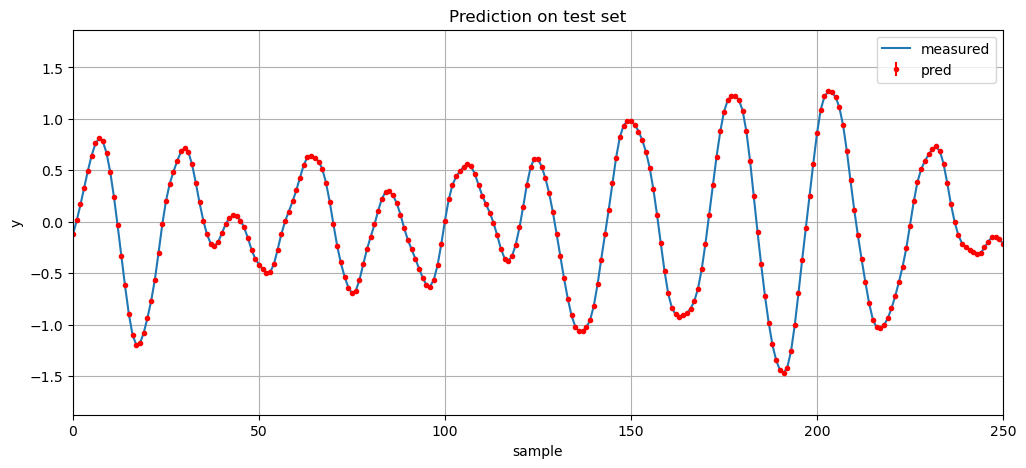

Test prediction NRMS: 0.87 %


In [5]:
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain_NARX,return_std=True)
plt.figure(figsize=(12,5))
plt.plot(Ytrain_NARX)
plt.title('Prediction on train set')
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain_NARX,return_std=True)
plt.errorbar(np.arange(len(Xtrain_NARX)), (Ytrain_pred), yerr=2*Ytrain_pred_std,fmt='.r')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.xlim([0, 250])
plt.show()

NRMS_train_pred = calculate_error_nrms(Ytrain_pred, Ytrain_NARX)
print(f'Train prediction NRMS: {NRMS_train_pred:.2f} %')

plt.figure(figsize=(12,5))
plt.title('Prediction on validation set')
plt.plot(Yval_NARX)
Yval_pred, Yval_pred_std = reg.predict(Xval_NARX,return_std=True)
plt.errorbar(np.arange(len(Xval_NARX)), (Yval_pred), yerr=2*Yval_pred_std,fmt='.r')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.xlim([0, 250])
plt.show()

NRMS_val_pred = calculate_error_nrms(Yval_pred, Yval_NARX)
print(f'Validation prediction NRMS: {NRMS_val_pred:.2f} %')

plt.figure(figsize=(12,5))
plt.title('Prediction on test set')
plt.plot(Ytest_NARX)
Ytest_pred, Ytest_pred_std = reg.predict(Xtest_NARX,return_std=True)
plt.errorbar(np.arange(len(Xtest_NARX)), (Ytest_pred), yerr=2*Ytest_pred_std,fmt='.r')
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['measured','pred'])
plt.xlim([0, 250])
plt.show()

NRMS_test_pred = calculate_error_nrms(Ytest_pred, Ytest_NARX)
print(f'Test prediction NRMS: {NRMS_test_pred:.2f} %')

### Run simulation

In [6]:
Xtrain,Ytrain = load_data(section="train", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
Xval,Yval = load_data(section="validation", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
Xtest,Ytest = load_data(section="test", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)

Considering 25000 datapoints
Using 15000 datapoints for training set
Considering 25000 datapoints
Using 5000 datapoints for validation set
Considering 25000 datapoints
Using 5000 datapoints for test set


In [7]:
def use_NARX_model_in_simulation(ulist, f, na, nb):
    #init upast and ypast as lists.
    upast = [0]*nb 
    ypast = [0]*na 
    
    ylist = []
    for unow in ulist:
        #compute the current y given by f
        ynow = f(upast,ypast) 
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

In [8]:
sim_model = lambda u,y: reg.predict(np.concatenate([u,y])[None,:])[0] 

In [9]:
Ytrain_sim = use_NARX_model_in_simulation(Xtrain, sim_model, n_a, n_b)

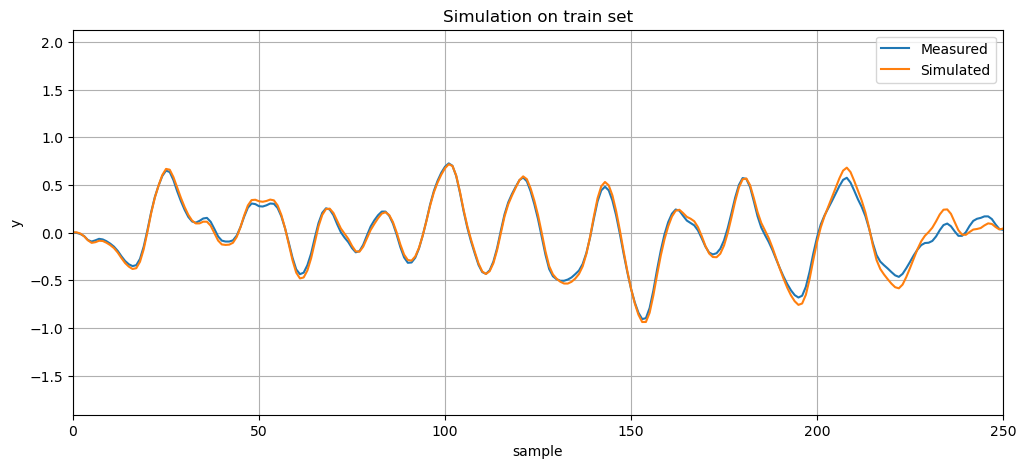

Train simulation NRMS: 10.29 %


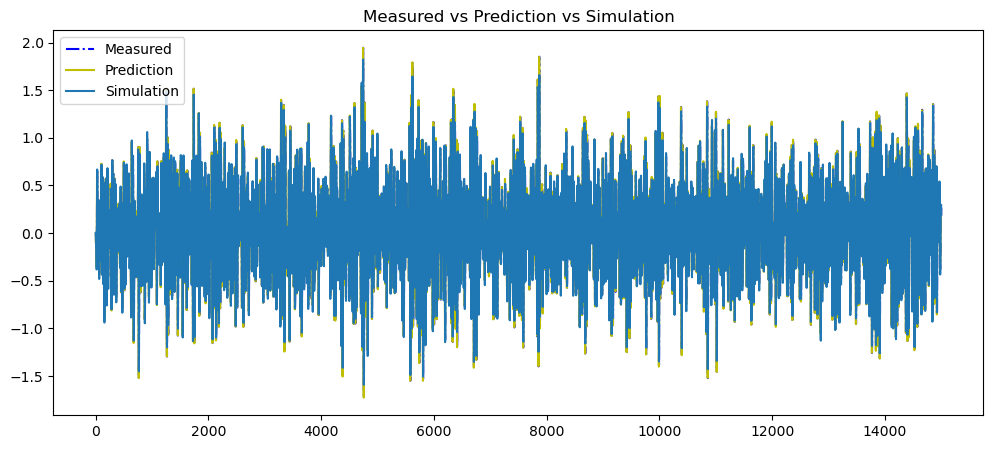

Train prediction NRMS: 0.90 %
Train simulation NRMS: 10.29 %


In [10]:
plt.figure(figsize=(12,5))
plt.title('Simulation on train set')
plt.plot(Ytrain)
plt.plot(Ytrain_sim)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['Measured','Simulated'])
plt.xlim([0, 250])
plt.show()

NRMS_train_sim = calculate_error_nrms(Ytrain_sim, Ytrain)
print(f'Train simulation NRMS: {NRMS_train_sim:.2f} %')

plt.figure(figsize=(12,5))
plt.plot(Ytrain,'b-.')
plt.plot(Ytrain_pred, 'y')
plt.plot(Ytrain_sim)
plt.title("Measured vs Prediction vs Simulation")
plt.legend(['Measured','Prediction','Simulation'])
plt.show()

print(f'Train prediction NRMS: {NRMS_train_pred:.2f} %')
print(f'Train simulation NRMS: {NRMS_train_sim:.2f} %')

In [11]:
Yval_sim = use_NARX_model_in_simulation(Xval, sim_model, n_a, n_b)

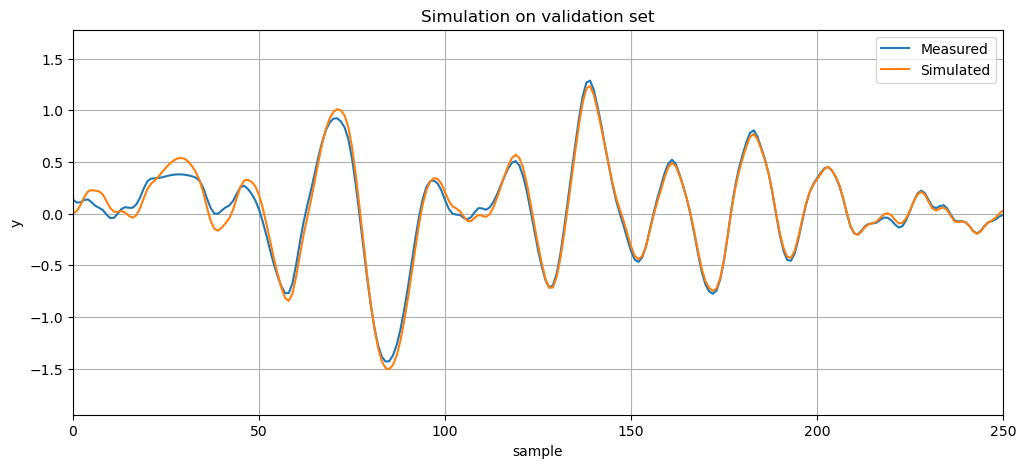

Validation simulation NRMS: 12.18 %


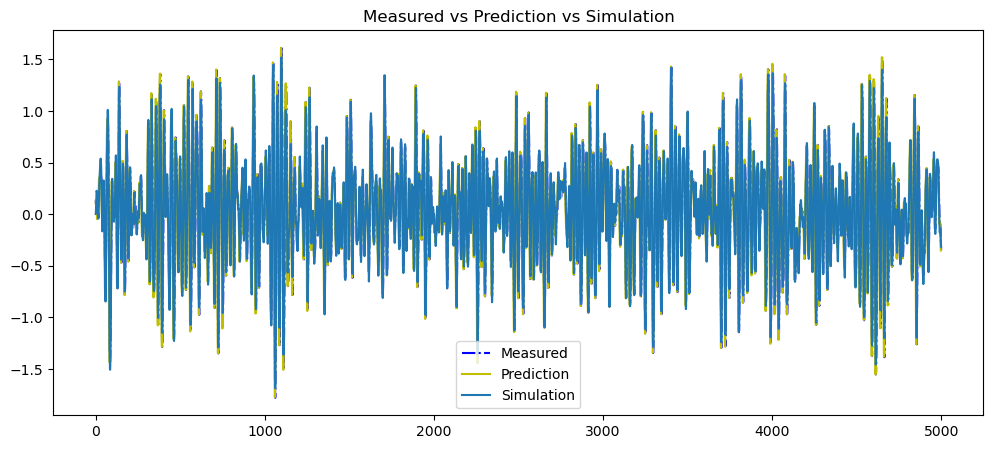

Validation prediction NRMS: 0.81 %
Validation simulation NRMS: 12.18 %


In [12]:
plt.figure(figsize=(12,5))
plt.title('Simulation on validation set')
plt.plot(Yval)
plt.plot(Yval_sim)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['Measured','Simulated'])
plt.xlim([0, 250])
plt.show()

NRMS_val_sim = calculate_error_nrms(Yval_sim, Yval)
print(f'Validation simulation NRMS: {NRMS_val_sim:.2f} %')

plt.figure(figsize=(12,5))
plt.plot(Yval,'b-.')
plt.plot(Yval_pred, 'y')
plt.plot(Yval_sim)
plt.title("Measured vs Prediction vs Simulation")
plt.legend(['Measured','Prediction','Simulation'])
plt.show()

print(f'Validation prediction NRMS: {NRMS_val_pred:.2f} %')
print(f'Validation simulation NRMS: {NRMS_val_sim:.2f} %')

In [13]:
Ytest_sim = use_NARX_model_in_simulation(Xtest, sim_model, n_a, n_b)

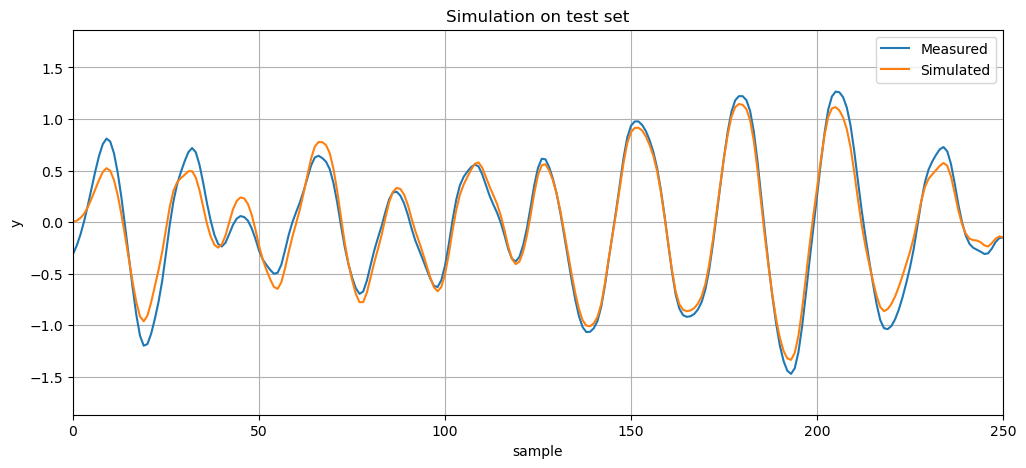

Test simulation NRMS: 14.85 %


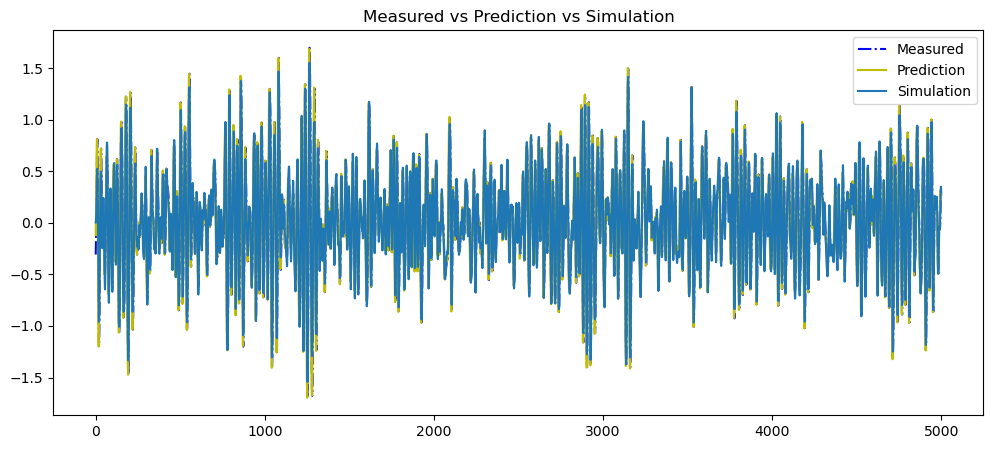

Test prediction NRMS: 0.87 %
Test simulation NRMS: 14.85 %


In [14]:
plt.figure(figsize=(12,5))
plt.title('Simulation on test set')
plt.plot(Ytest)
plt.plot(Ytest_sim)
plt.grid(); plt.xlabel('sample'); plt.ylabel('y'); plt.legend(['Measured','Simulated'])
plt.xlim([0, 250])
plt.show()

NRMS_test_sim = calculate_error_nrms(Ytest_sim, Ytest)
print(f'Test simulation NRMS: {NRMS_test_sim:.2f} %')

plt.figure(figsize=(12,5))
plt.plot(Ytest,'b-.')
plt.plot(Ytest_pred, 'y')
plt.plot(Ytest_sim)
plt.title("Measured vs Prediction vs Simulation")
plt.legend(['Measured','Prediction','Simulation'])
plt.show()

print(f'Test prediction NRMS: {NRMS_test_pred:.2f} %')
print(f'Test simulation NRMS: {NRMS_test_sim:.2f} %')

## Final results

In [15]:
data = {
    'Prediction': [NRMS_train_pred, NRMS_val_pred, NRMS_test_pred],
    'Simulation': [NRMS_train_sim, NRMS_val_sim, NRMS_test_sim]
}

index = ['Train', 'Validation', 'Test']

df = pd.DataFrame(data, index=index)

df = df.round(2)

display(df)


,Prediction,Simulation
Train,0.90,10.29
Validation,0.81,12.18
Test,0.87,14.85
